<a href="https://colab.research.google.com/github/fsclsnow/AML/blob/master/AML_Project4_PM2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4 - Jiajie Zhu

This notebook performs experiments involving regression using the Beijing PM2.5 Data Set:
*   The hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included.
*   PM2. 5 refers to atmospheric particulate matter (PM) that have a diameter of less than 2.5 micrometers, which is about 3% the diameter of a human hair.
*   Commonly written as PM2.5, particles in this category are so small that they can only be detected with an electron microscope.



In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
# Download the data
import urllib
import os

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/fsclsnow/AML/master/"
PM25_PATH = os.path.join("Data")
PM25_URL = DOWNLOAD_ROOT + "Data/PRSA_data.csv"

In [0]:
import pandas as pd

def load_pm_data(pm_path=PM25_PATH):
    csv_path = os.path.join(DOWNLOAD_ROOT, pm_path, "PRSA_data.csv")
    return pd.read_csv(csv_path)

In [0]:
pm25 = load_pm_data()
pm25.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
pm25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [0]:
pm25.shape

(43824, 13)

In [0]:
pm25.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


Saving figure attribute_histogram_plots


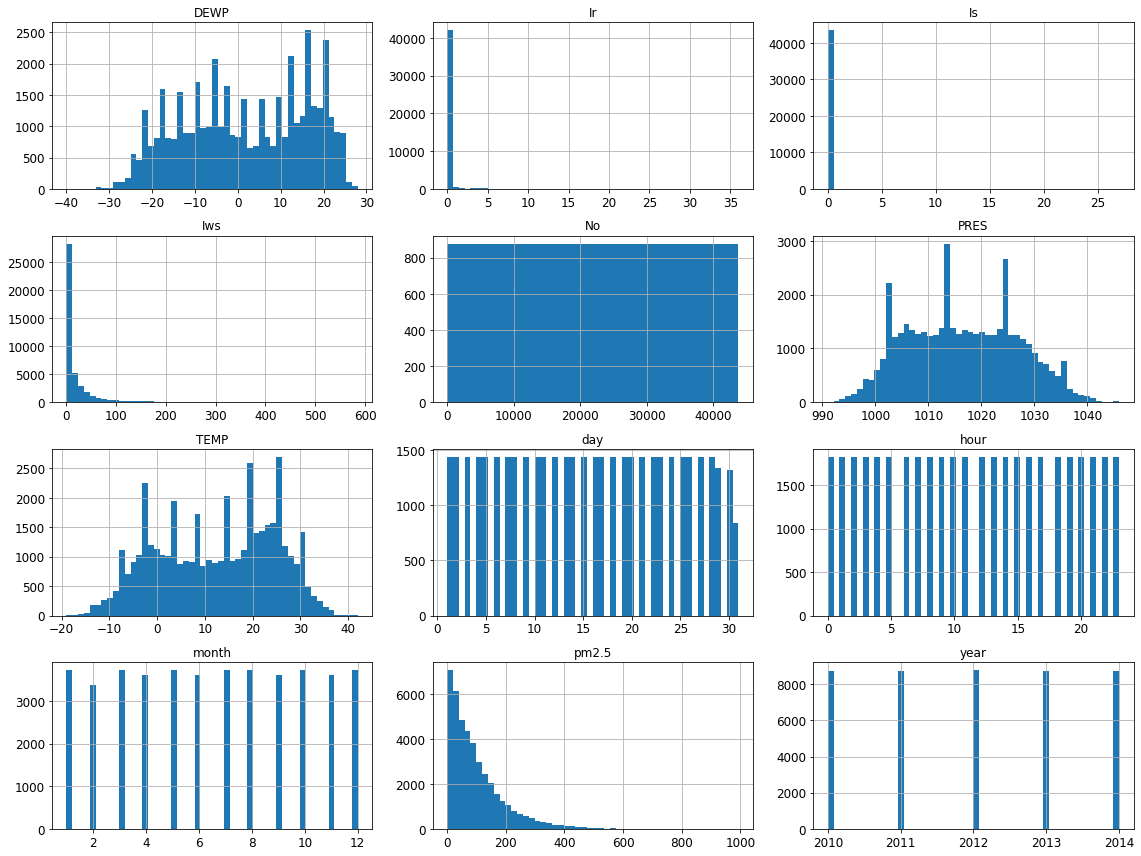

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
pm25.hist(bins=50, figsize=(16,12))
save_fig("attribute_histogram_plots")
plt.show()

In [0]:
sample_incomplete_rows = pm25[pm25.isnull().any(axis=1)].head()
sample_incomplete_rows

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Next, we'll replace empty data with 'median value'.

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
median = pm25["pm2.5"].median()
median

72.0

In [0]:
pm25["pm2.5"].fillna(median, inplace=True)

In [0]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [0]:
train_set, test_set = split_train_test(pm25, 0.2)
len(train_set)

35060

In [0]:
len(test_set)

8764

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(pm25, test_size=0.2, random_state=42)

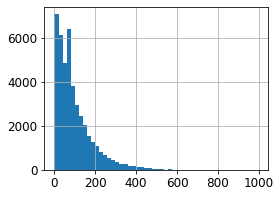

In [0]:
pm25["pm2.5"].hist(bins=50, figsize=(4,3))

We can observed that there is a abnormal peak around 70s which is the large amount of missing data replaced by the median which is 72.

Set PM2.5 categorical label with AQI Category. (Reference: https://aqicn.org/faq/2013-09-09/revised-pm25-aqi-breakpoints/)

*   Good: 0.0 - 12.0
*   Moderate: 12.1 – 35.4 
*   Unhealthy for Sensitive Groups: 35.5 – 55.4
*   Unhealthy: 55.5 – 150.4
*   Very Unhealthy: 150.5 – 250.4
*   Hazardous: > 250.4





In [0]:
pm25["pm25_cat"] = pd.cut(pm25["pm2.5"],
                               bins=[0.0, 12.1, 35.4, 55.4, 150.4, 250.4, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

In [0]:
sample_incomplete_rows = pm25[pm25.isnull().any(axis=1)].head()
sample_incomplete_rows

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm25_cat
24034,24035,2012,9,28,10,0.0,-5,20.0,1020.0,NW,139.48,0,0,NaN
24039,24040,2012,9,28,15,0.0,-10,24.0,1017.0,NW,192.68,0,0,NaN


It is unknown why pm25_cat were set to NaN when the giving value of pm2.5 is 0.0. In order to avoid further error, we manually replace these NaN with 1 correspond to the pm2.5 value.

In [0]:
pm25["pm25_cat"].fillna(1, inplace=True)

In [0]:
pm25["pm25_cat"].value_counts()

4    17710
2     8733
5     5938
3     5003
1     3387
6     3053
Name: pm25_cat, dtype: int64

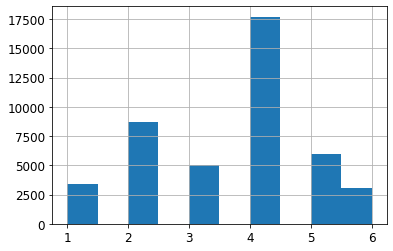

In [0]:
pm25["pm25_cat"].hist()

In [0]:
pm25["pm25_cat"].describe()

count     43824
unique        6
top           4
freq      17710
Name: pm25_cat, dtype: int64

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(pm25, pm25["pm25_cat"]):
    strat_train_set = pm25.loc[train_index]
    strat_test_set = pm25.loc[test_index]

In [0]:
# pm25.drop("pm25_cat", axis=1, inplace=True)

In [0]:
corr_matrix = pm25.corr()
corr_matrix["pm2.5"].sort_values(ascending=False)

pm2.5    1.000000
DEWP     0.165696
day      0.079172
Is       0.020192
year    -0.005805
No      -0.009091
hour    -0.022435
month   -0.024286
PRES    -0.046337
Ir      -0.050135
TEMP    -0.089115
Iws     -0.239623
Name: pm2.5, dtype: float64

The attribute with the highest corelation is Iws(Cumulated wind speed). Second highest is DEWP (Dew Point (â„ƒ)).

Saving figure scatter_matrix_plot


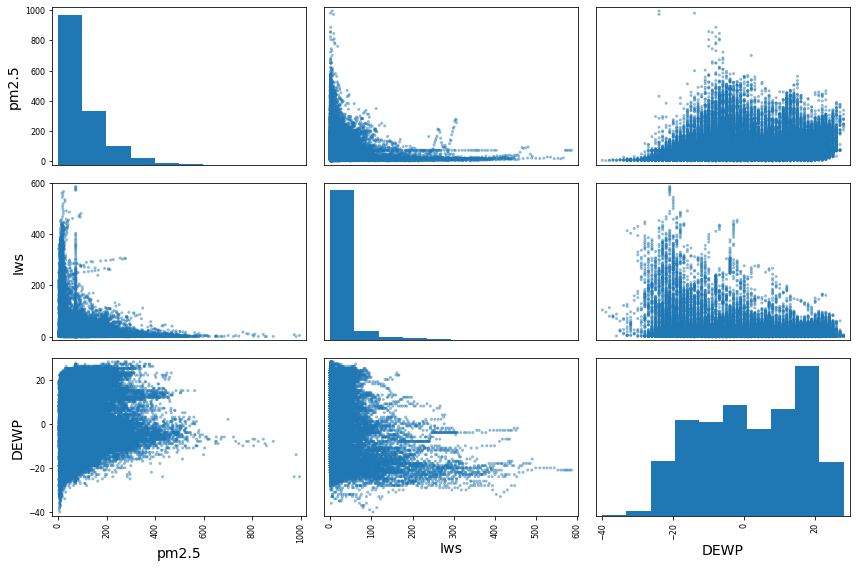

In [0]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["pm2.5", "Iws", "DEWP"]
scatter_matrix(pm25[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

# Prepare the data for Machine Learning algorithms

In [0]:
pm25 = strat_train_set.drop("pm2.5", axis=1) # drop labels for training set
pm25_labels = strat_train_set["pm2.5"].copy()

Remove the text attribute because median can only be calculated on numerical attributes:

In [0]:
pm_num = pm25.drop("cbwd", axis=1)
# alternatively: pm_num = pm25.select_dtypes(include=[np.number])

In [0]:
imputer.fit(pm_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [0]:
sample_incomplete_rows = pm_num[pm_num.isnull().any(axis=1)].head()
sample_incomplete_rows

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,pm25_cat


In [0]:
imputer.statistics_

array([2.1843e+04, 2.0120e+03, 7.0000e+00, 1.6000e+01, 1.2000e+01,
       2.0000e+00, 1.4000e+01, 1.0160e+03, 5.3700e+00, 0.0000e+00,
       0.0000e+00, 4.0000e+00])

Check that this is the same as manually computing the median of each attribute:

In [0]:
pm_num.median().values

array([2.1843e+04, 2.0120e+03, 7.0000e+00, 1.6000e+01, 1.2000e+01,
       2.0000e+00, 1.4000e+01, 1.0160e+03, 5.3700e+00, 0.0000e+00,
       0.0000e+00, 4.0000e+00])

Transform the training set:

In [0]:
X = imputer.transform(pm_num)

In [0]:
pm_tr = pd.DataFrame(X, columns=pm_num.columns,
                          index=pm25.index)

In [0]:
imputer.strategy

'median'

In [0]:
pm_tr = pd.DataFrame(X, columns=pm_num.columns,
                          index=pm_num.index)

Now let's preprocess the categorical input feature, cbwd (combined wind direction ):

In [0]:
pm_cat = pm25[["cbwd"]]
pm_cat.head(10)

,cbwd
11426,cv
3209,NW
5601,NE
16541,NW
38421,SE
7637,NW
15799,NW
37157,NW
4509,SE
4391,cv


In [0]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
pm_cat_encoded = ordinal_encoder.fit_transform(pm_cat)
pm_cat_encoded[:10]

array([[3.],
       [1.],
       [0.],
       [1.],
       [2.],
       [1.],
       [1.],
       [1.],
       [2.],
       [3.]])

In [0]:
ordinal_encoder.categories_

[array(['NE', 'NW', 'SE', 'cv'], dtype=object)]

In [0]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
pm_cat_1hot = cat_encoder.fit_transform(pm_cat)
pm_cat_1hot

<35059x4 sparse matrix of type '<class 'numpy.float64'>'
	with 35059 stored elements in Compressed Sparse Row format>

By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:

In [0]:
pm_cat_1hot.toarray()

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Alternatively, you can set sparse=False when creating the OneHotEncoder:

In [0]:
cat_encoder = OneHotEncoder(sparse=False)
pm_cat_1hot = cat_encoder.fit_transform(pm_cat)
pm_cat_1hot

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [0]:
cat_encoder.categories_

[array(['NE', 'NW', 'SE', 'cv'], dtype=object)]

Now let's build a pipeline for preprocessing the numerical attributes:

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

pm_tr = num_pipeline.fit_transform(pm_num)

In [0]:
pm_tr

array([[-0.82537383, -0.70431538, -0.72831715, ..., -0.06925803,
        -0.13614094,  0.35006494],
       [-1.47507291, -1.41194091, -0.43884475, ..., -0.06925803,
         1.31703771,  1.09532404],
       [-1.28594304, -1.41194091,  0.42957245, ..., -0.06925803,
        -0.13614094, -1.14045325],
       ...,
       [ 0.98733169,  0.71093568,  1.58746206, ..., -0.06925803,
        -0.13614094,  0.35006494],
       [-0.05976153,  0.00331015, -0.43884475, ..., -0.06925803,
        -0.13614094,  0.35006494],
       [ 0.65864736,  0.71093568, -0.14937235, ..., -0.06925803,
        -0.13614094, -1.14045325]])

In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(pm_num)
cat_attribs = ["cbwd"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

pm_prepared = full_pipeline.fit_transform(pm25)

In [0]:
pm_prepared.shape

(35059, 16)

# Train a linear model 

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(pm_prepared, pm25_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# let's try the full preprocessing pipeline on a few training instances
some_data = pm25.iloc[:5]
some_labels = pm25_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [118.42085187 177.56737468   2.8482692  136.30694225 114.97061627]


Compare against the actual values:

In [0]:
print("Labels:", list(some_labels))

Labels: [72.0, 158.0, 32.0, 102.0, 121.0]


In [0]:
some_data_prepared

array([[-0.82537383, -0.70431538, -0.72831715,  0.71329103, -1.37220151,
         0.22769671, -0.44246827,  0.24230326, -0.43479092, -0.06925803,
        -0.13614094,  0.35006494,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-1.47507291, -1.41194091, -0.43884475, -0.19539513,  0.79398694,
         0.57408002,  0.70712854, -0.34232622, -0.41688471, -0.06925803,
         1.31703771,  1.09532404,  0.        ,  1.        ,  0.        ,
         0.        ],
       [-1.28594304, -1.41194091,  0.42957245,  0.71329103, -0.36131357,
         1.05901666,  0.87135666, -0.24488798, -0.34565776, -0.06925803,
        -0.13614094, -1.14045325,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.42094267, -0.70431538,  1.29798966,  0.59970526, -0.93896382,
        -0.53434657, -1.34572292,  1.41156222, -0.31004429, -0.06925803,
        -0.13614094,  0.35006494,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 1.30905806,  1.41856121, -0

In [0]:
from sklearn.metrics import mean_squared_error
pm25_predictions = lin_reg.predict(pm_prepared)
lin_mse = mean_squared_error(pm25_labels, pm25_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

46.12552122058084

In [0]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(pm25_labels, pm25_predictions)
lin_mae

32.495076095689946

In [0]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(pm_prepared, pm25_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [0]:
housing_predictions = tree_reg.predict(pm_prepared)
tree_mse = mean_squared_error(pm25_labels, pm25_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

46.12552122058084

K-cross validation for lin_reg with k=10

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, pm_prepared, pm25_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    10.000000
mean     46.098350
std       2.303943
min      42.295986
25%      44.688807
50%      46.521171
75%      46.701266
max      51.061303
dtype: float64

K-cross validation for tree_reg with k=10

In [0]:
scores = cross_val_score(tree_reg, pm_prepared, pm25_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [0]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [27.06252927 23.02848629 23.44452495 24.21805062 28.13786753 23.95099222
 23.63796269 24.28472485 25.97349893 23.99530387]
Mean: 24.773394122991427
Standard deviation: 1.610243682401645


In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(pm_prepared, pm25_labels)
lin_reg.intercept_, lin_reg.coef_

(98.27627289572806,
 array([ 3.23312504e+03, -3.16446481e+03, -6.44781936e+02, -5.22992556e+01,
        -1.50006507e-02, -3.37633498e-01, -6.97939607e+00, -3.37276850e+00,
         1.85079043e+00, -1.18848744e+00, -6.24540858e-01,  7.86228156e+01,
         4.18023453e+00,  6.55158981e+00, -9.23045415e+00, -1.50137018e+00]))

We are unable to draw a graph here, because this linear regression has 16 independent variables.

In [0]:
X = pm_prepared
y = pm25_labels
X_b = np.c_[np.ones((35059, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [0]:
theta_best

array([ 2.54083270e+03, -1.04682252e+07,  1.02551921e+07,  2.08942758e+06,
        1.74569836e+05,  7.01455286e+03,  2.81146658e+03, -6.95463012e+03,
        2.95584738e+03, -6.47764455e+02,  2.42783389e+02, -1.37690053e+02,
       -8.82980012e+01, -2.38754309e+03, -2.08845050e+03, -2.78333148e+03,
       -2.82032220e+03])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for "least squares"), which you could call directly:

In [0]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([ 7.86210183e+01,  3.23312504e+03, -3.16446481e+03, -6.44781936e+02,
       -5.22992556e+01, -1.50006507e-02, -3.37633498e-01, -6.97939607e+00,
       -3.37276850e+00,  1.85079043e+00, -1.18848744e+00, -6.24540858e-01,
        7.86228156e+01,  2.38354891e+01,  2.62068444e+01,  1.04248004e+01,
        1.81538844e+01])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the pseudoinverse of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

In [0]:
np.linalg.pinv(X_b).dot(y)

array([ 7.86210183e+01,  3.23312504e+03, -3.16446481e+03, -6.44781936e+02,
       -5.22992556e+01, -1.50006507e-02, -3.37633498e-01, -6.97939607e+00,
       -3.37276850e+00,  1.85079043e+00, -1.18848744e+00, -6.24540858e-01,
        7.86228156e+01,  2.38354891e+01,  2.62068444e+01,  1.04248004e+01,
        1.81538844e+01])

# Linear regression using batch gradient descent

Normal linear regression model with BGD is unable to apply to multi-variable data set.

Let's only take pm2.5 and the most corelated attribute "Iws" for further training and testing.

In [0]:
pm25_lws = strat_train_set["Iws"].copy()

In [0]:
pm25_lws = pm25_lws.values.reshape(-1,1)

In [0]:
pm25_labels = pm25_labels.values.reshape(-1,1)

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(pm_prepared, pm25_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now, scaling the data with StandardScaler.

In [0]:
pm_tr_new = num_pipeline.fit_transform(pm25_lws)

Saving figure generated_data_plot


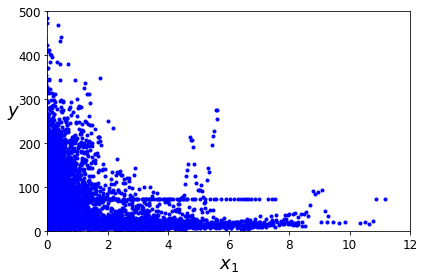

In [0]:
X = pm_tr_new
y = pm25_labels

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 12, 0, 500])
save_fig("generated_data_plot")
plt.show()

# Linear regression using the Normal Equation

In [0]:
X_b = np.c_[np.ones((35059, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [0]:
theta_best

array([[ 97.31261588],
       [-21.54719087]])

In [0]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[97.31261588],
       [54.21823413]])

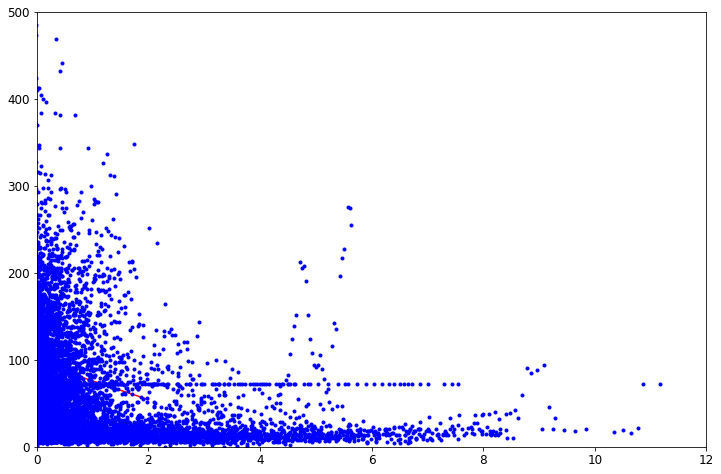

In [0]:
plt.figure(figsize=(12,8))
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 12, 0, 500])
plt.show()

We can vagurely observed the red line behind the heavy densed blut dots.

Saving figure linear_model_predictions_plot


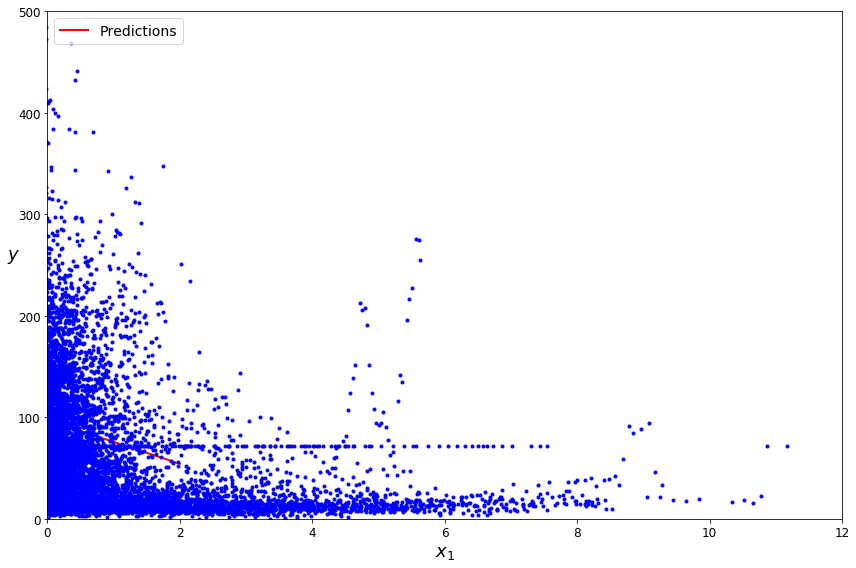

In [0]:
plt.figure(figsize=(12,8))
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 12, 0, 500])
save_fig("linear_model_predictions_plot")
plt.show()

The predicted red line is severely covered by the blue dots. 

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([97.31261588]), array([[-21.54719087]]))

In [0]:
lin_reg.predict(X_new)

array([[97.31261588],
       [54.21823413]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [0]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[ 97.31261588],
       [-21.54719087]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [0]:
np.linalg.pinv(X_b).dot(y)

array([[ 97.31261588],
       [-21.54719087]])

# Linear regression using batch gradient descent

In [0]:
eta = 0.01  # learning rate
n_iterations = 6000
m = 35059

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [0]:
theta

array([[ 97.31261588],
       [-21.54719087]])

Exactly the same with Normal Equation.

In [0]:
X_new_b.dot(theta)

array([[97.31261588],
       [54.21823413]])

In [0]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 5000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "y-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 12, 0, 500])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


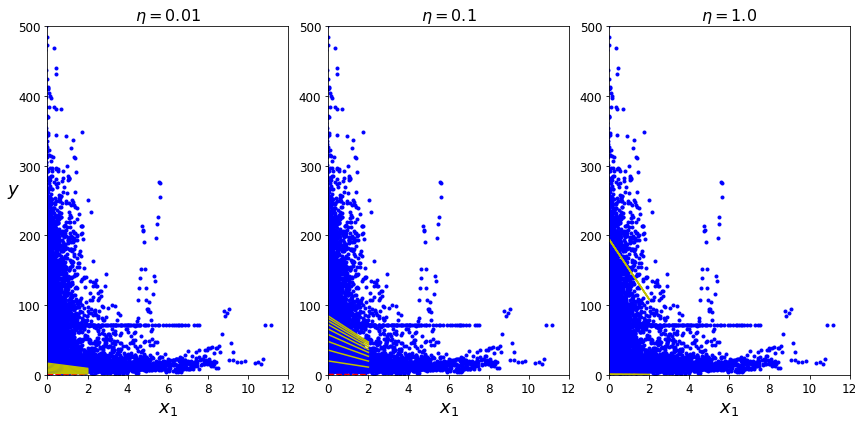

In [0]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(12,6))
plt.subplot(131); plot_gradient_descent(theta, eta=0.01)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=1.0)

save_fig("gradient_descent_plot")
plt.show()

From the plots above we can observed that eta=0.1 is good approach while eta=1.0 deviated a lot and eta=0.01 exhausted too many trials.

# Let's see how does Stochastic Gradient Descent work?

In [0]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

Saving figure sgd_plot


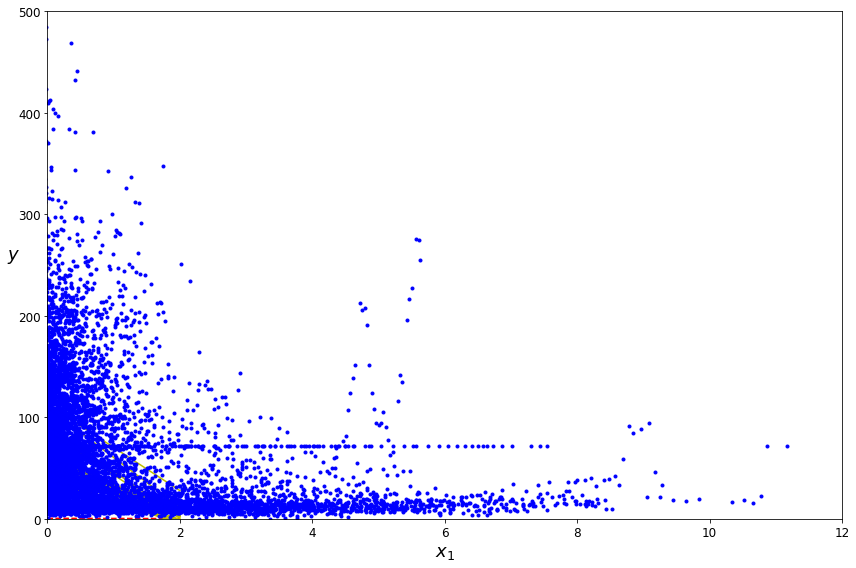

In [0]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization
plt.figure(figsize=(12,8))
for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "y-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown


plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 12, 0, 500])                            # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()                                           # not shown

It tooks a little while, but it worked.Unfortunately, the prediction line can barely see with the highly densed blut dots.

In [0]:
theta

array([[ 97.54925455],
       [-21.55643425]])

In [0]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [0]:
sgd_reg.intercept_, sgd_reg.coef_

(array([96.84905879]), array([-22.71510606]))

Mini-batch gradient descent

In [0]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [0]:
theta

array([[ 97.45738789],
       [-21.10579827]])

In [0]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


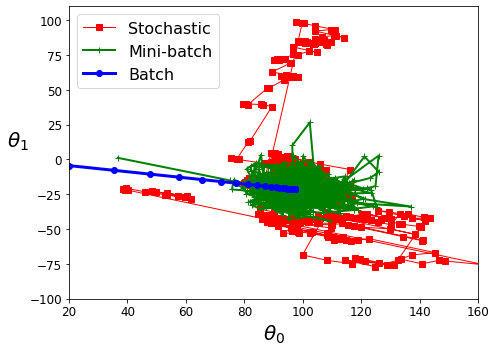

In [0]:
plt.figure(figsize=(7,5))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([20, 160, -100, 110])
save_fig("gradient_descent_paths_plot")
plt.show()

From the plot above we can observed that:
*  Batch approach the target directly although it takes more time
*  SGD go all over the place because it takes random samples
*  MBGD have more diversion than BGD because it takes sub-sets.

In addition, since the sample size is not too big, even BDG didn't take much time to run, while both SGD and MBGD experienced slice level of deviance in the result compare to Normal Equation. 

**Therefore, for this data set, BGD with eta=0.1 is recommended. Even normal equation is quite acceptable.**

# Polynomial regression

In [0]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.43479092])

In [0]:
X_poly[0]

array([-0.43479092,  0.18904314])

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([92.33724993]), array([[-42.67936221,   4.97536595]]))

Saving figure quadratic_predictions_plot


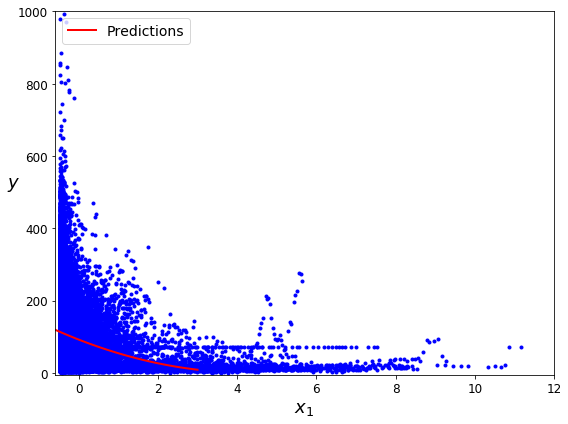

In [0]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.figure(figsize=(8,6))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-0.6, 12, -5, 1000])
save_fig("quadratic_predictions_plot")
plt.show()

Saving figure quadratic_predictions_plot


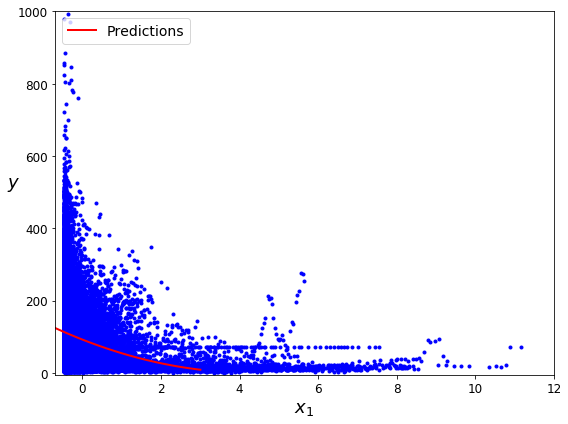

In [0]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.figure(figsize=(8,6))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-0.7, 12, -5, 1000])
save_fig("quadratic_predictions_plot")
plt.show()

In [0]:
from scipy import stats
stats.describe(y)

DescribeResult(nobs=35059, minmax=(array([0.]), array([994.])), mean=array([97.31261588]), variance=array([8078.11762593]), skewness=array([1.88569543]), kurtosis=array([5.4153575]))

In [0]:
stats.describe(X)

DescribeResult(nobs=35059, minmax=(array([-0.47020543]), array([11.17181826])), mean=array([3.14139377e-17]), variance=array([1.00002852]), skewness=array([4.24736021]), kurtosis=array([22.71214866]))

Since poly = 300 causes numbers that could not be handled with float64, we use poly = 100 for the test.

Because the data dots are too densed, we separate the prediction lines for a more clear look.

No handles with labels found to put in legend.


Saving figure high_degree_polynomials_plot


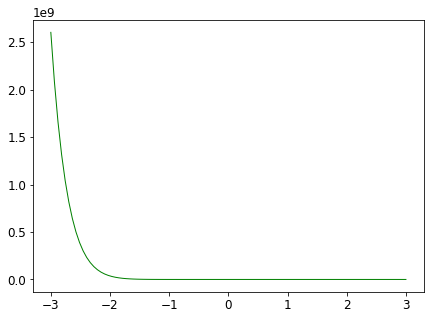

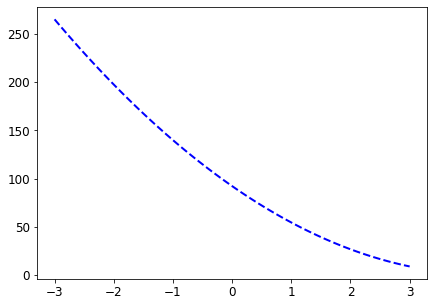

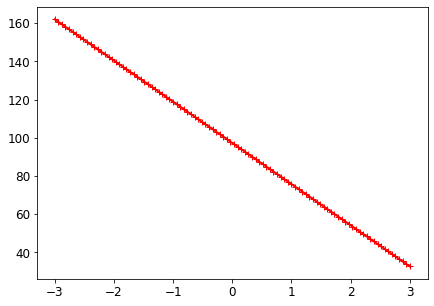

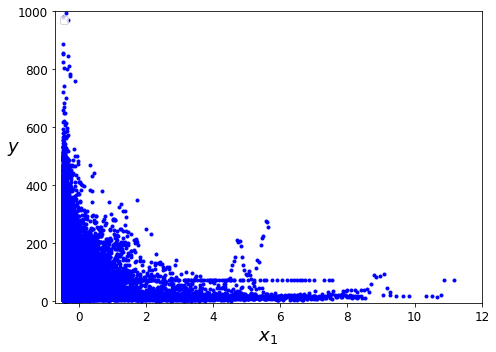

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 100), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.figure(figsize=(7,5))
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.figure(figsize=(7,5))
plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-0.7, 12, -5, 1000])
save_fig("high_degree_polynomials_plot")
plt.show()

From the data graph we can see that the data set is definitely not linear related, even poly = 2 is not enough. 

From the chart above, we can see that high poly number is more preferred here.

Learning curve of a plain Linear Regression model on the same data.

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.figure(figsize=(10,6))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


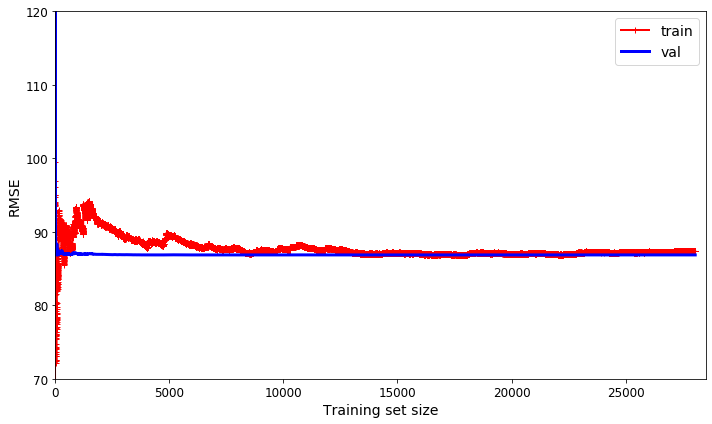

In [0]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 28500, 70, 120])                   # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

Learning curve of a 10th-degree polynomial model on the same data.

Saving figure learning_curves_plot


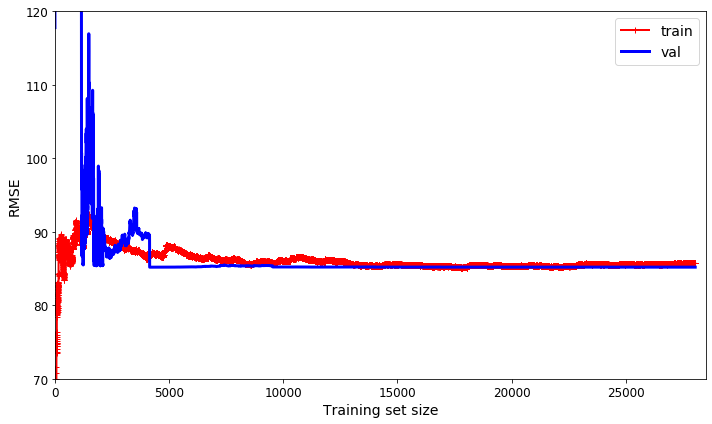

In [0]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 28500, 70, 120])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()                        # not shown

With all attributes considered, we find non-linear regression model (DT) has better performance with a lower mean squared error. 

While considering the most related attribute Iws as independent variable, we observed that high degrees polynomial regression has drawn the curve that fitting the data better compare to the linear regression models. 

When using linear regression models on this dataset, BDG with eta=0.1 is recommended as well as normal equation.